In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#import statsmodels.api as sm
#import itertools as it
#from statsmodels.sandbox.stats.multicomp import multipletests
#from itertools import compress
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from collections import Counter
import networkx as nx

In [2]:
def read_regionfile(directory, file_name):
    with open(directory + file_name) as f:
        gems = {}
        for line in f:
            tmp = line.strip().split("\t")
            gemid = tmp[4]
            if tmp[5] != ".":
                if gemid in gems.keys():
                    gems[gemid].append(tmp[5])
                else:
                    gems[gemid] = [tmp[5]]
    return gems

In [3]:
def read_se(directory, file_name):
    with open(directory + file_name) as f:
        seid = []
        for line in f:
            tmp = line.strip().split("\t")
            se = tmp[3]
            seid.append(se)
    return seid

In [6]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (5,8))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    plt.ylim(top=1000)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [7]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [8]:
directory='/Users/kimm/Desktop/GM12878_files/'
rnapiise_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS.SE_G33kboverlap.region'
rnapiipse_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS.PSEtrunc100kboverlap.region'
cohesinse_rfile='GM12878-cohesin-pooled_comp_FDR_0.2_PASS.SE_G33kboverlap.region'
cohesinpse_rfile='GM12878-cohesin-pooled_comp_FDR_0.2_PASS.PSEtrunc100kboverlap.region'
ctcfse_rfile='GM12878-CTCF-pooled_comp_FDR_0.2_PASS.SE_G33kboverlap.region'
ctcfpse_rfile='GM12878-CTCF-pooled_comp_FDR_0.2_PASS.PSEtrunc100kboverlap.region'
se_file='GM12878_superenhancer_hg38_G33kb.bed'
pse_file='GM12878_pseudosuperenhancer_hg38_l300kb_n1000_s1234.sorted.trunc100kb.bed'

In [9]:
se = read_se(directory, se_file)

In [10]:
pse = read_se(directory, pse_file)

In [11]:
rnapiiser = read_regionfile(directory, rnapiise_rfile)

In [12]:
rnapiipser = read_regionfile(directory,rnapiipse_rfile)

In [13]:
cohesinser = read_regionfile(directory, cohesinse_rfile)

In [14]:
cohesinpser = read_regionfile(directory, cohesinpse_rfile)

In [15]:
ctcfser = read_regionfile(directory, ctcfse_rfile)

In [16]:
ctcfpser = read_regionfile(directory, ctcfpse_rfile)

In [17]:
def reg2fcnt(ser, se):
    sef_dict = {}
    for k, v in ser.items():
        fbyse = Counter(v)
        for key, val in fbyse.items():
            if key in sef_dict.keys():
                sef_dict[key].append(val)
            else:
                sef_dict[key] = [val]
    for x in se:
        if x not in sef_dict.keys():
            sef_dict[x] = []
    return sef_dict

In [18]:
def ser2comp(ser, se):
    sef_dict = reg2fcnt(ser, se)
    sef_comp = []
    for k,v in sef_dict.items():
        sef_comp.append(len([x for x in v if x > 1]))
    return sef_comp

In [19]:
rnapiisef_comp = ser2comp(rnapiiser, se)

In [20]:
rnapiipsef_comp = ser2comp(rnapiipser, pse)

In [21]:
cohesinsef_comp = ser2comp(cohesinser, se)
cohesinpsef_comp = ser2comp(cohesinpser, pse)

In [22]:
ctcfsef_comp = ser2comp(ctcfser, se)
ctcfpsef_comp = ser2comp(ctcfpser, pse)

In [23]:
stat = scipy.stats.mannwhitneyu(rnapiisef_comp, rnapiipsef_comp)

In [24]:
title = "RNAPII complexes >=2 frags within region \n SE vs random \n  SE: median = " + str(int(np.median(rnapiisef_comp))) + "; n = " + str(len(rnapiisef_comp)) + "\n" + "Random: median = " + str(int(np.median(rnapiipsef_comp))) + "; n = " + str(len(rnapiipsef_comp)) + "\n" + "Mann-Whitney stat = " + str(stat[0]) + "; pval = " + str(stat[1]) 

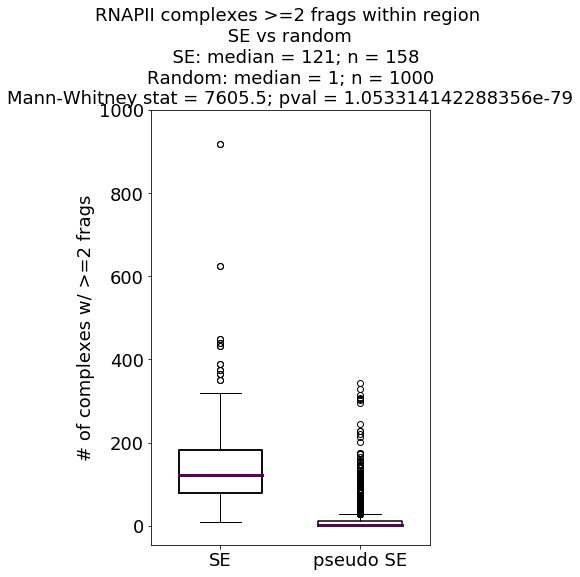

In [26]:
plot_boxplot([rnapiisef_comp, rnapiipsef_comp], ['SE', 'pseudo SE'], "#590059", title, "# of complexes w/ >=2 frags", 'GM12878_RNAPII_0.2PASS_SE_vs_random_intra-interactions_boxplot_20200828_v5')

In [27]:
stat = scipy.stats.mannwhitneyu(cohesinsef_comp, cohesinpsef_comp)

In [28]:
title = "Cohesin complexes >=2 frags within region \n SE vs random \n  SE: median = " + str(int(np.median(cohesinsef_comp))) + "; n = " + str(len(cohesinsef_comp)) + "\n" + "Random: median = " + str(int(np.median(cohesinpsef_comp))) + "; n = " + str(len(cohesinpsef_comp)) + "\n" + "Mann-Whitney stat = " + str(stat[0]) + "; pval = " + str(stat[1]) 

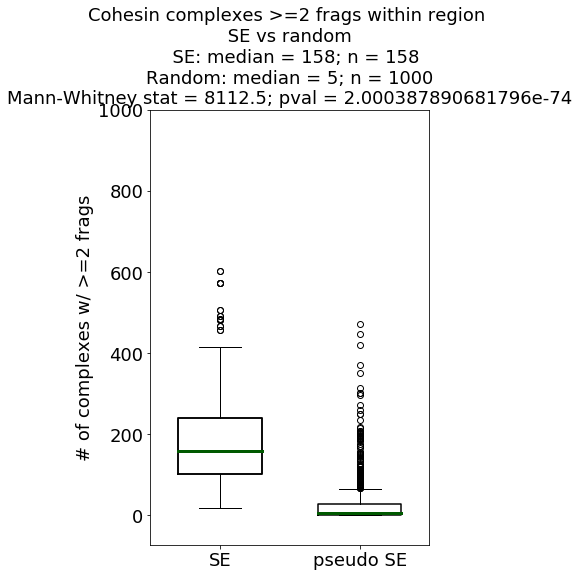

In [29]:
plot_boxplot([cohesinsef_comp, cohesinpsef_comp], ['SE', 'pseudo SE'], "#005900", title, "# of complexes w/ >=2 frags", 'GM12878_Cohesin_0.2PASS_SE_vs_random_intra-interactions_boxplot_20200828_v5')

In [30]:
stat = scipy.stats.mannwhitneyu(ctcfsef_comp, ctcfpsef_comp)

In [31]:
title = "CTCF complexes >=2 frags within region \n SE vs random \n  SE: median = " + str(int(np.median(ctcfsef_comp))) + "; n = " + str(len(ctcfsef_comp)) + "\n" + "Random: median = " + str(int(np.median(ctcfpsef_comp))) + "; n = " + str(len(ctcfpsef_comp)) + "\n" + "Mann-Whitney stat = " + str(stat[0]) + "; pval = " + str(stat[1]) 

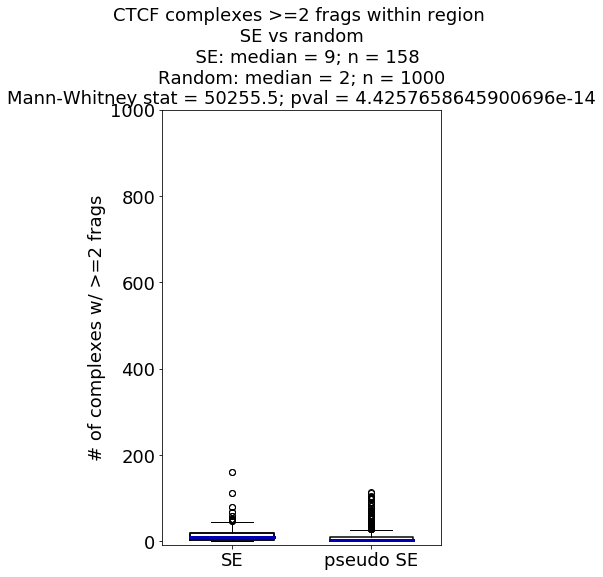

In [32]:
plot_boxplot([ctcfsef_comp, ctcfpsef_comp], ['SE', 'pseudo SE'], "#0000B2", title, "# of complexes w/ >=2 frags", 'GM12878_CTCF_0.2PASS_SE_vs_random_intra-interactions_boxplot_20200828_v5')